In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#CSR_MATRIX - compressed sparse row. for fast row slicing
from scipy.sparse import csr_matrix #to deal with 0 values
from sklearn.neighbors import NearestNeighbors

#Datasets
movies = pd.read_csv("./archive/movies.csv")
ratings = pd.read_csv("./archive/ratings.csv")


In [80]:
# pandas.dataframe.pivot() - returns reshape DF organized by index/column values
final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')

#so total we have 601 users and theirs datas(movie ratings)

In [81]:

# assigning NaN as 0 to make things undestandable for the algorithm
final_dataset.fillna(0, inplace=True)


In [87]:
# Removing Noise from the data(which is not useful)
# 1.To qualify a movie, a minimum of 10 users should have voted a movie.
# 2.To qualify a user, a minimum of 50 movies should have voted by the user.

# no_of_users voted a single movie in total(min 10 threshold)
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
# print(no_user_voted.head())
# print('*************')
# no of movies voted by a single user in total(min 50 threshold)
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')


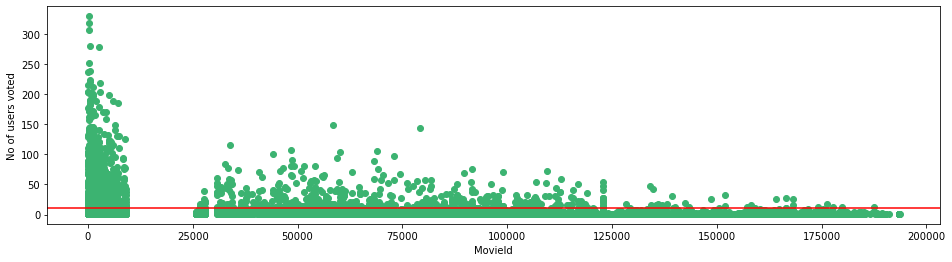

In [83]:
# Now visualizing the number of users who voted with our threshold of 10
# f is plt.figure() which is creating new figure or graph
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted, color="mediumseagreen")
plt.axhline(y = 10, color='red') # creating the horizontal threshold at 10
plt.xlabel('MovieId')
plt.ylabel('No of users voted')
plt.show()

In [84]:

final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]


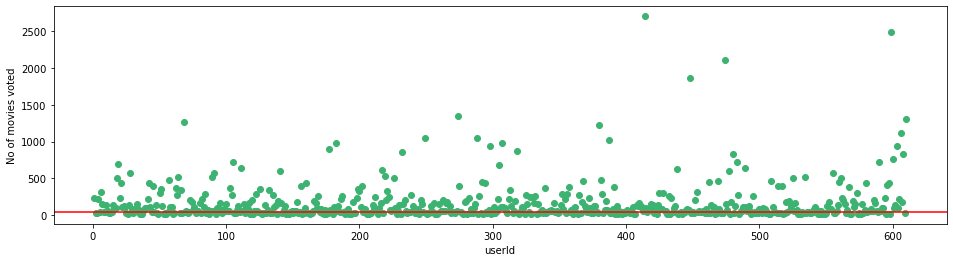

In [73]:
# No of movies voted by a particular user

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index, no_movies_voted, color="mediumseagreen")
plt.axhline(y = 50, color='red') # creating the horizontal threshold at 10
plt.xlabel('userId')
plt.ylabel('No of movies voted')
plt.show()

In [74]:
final_dataset = final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]

In [58]:
# removing sparsity (all 0 rating values)
# and this is done using csr_matrix
csr_data = csr_matrix(final_dataset.values)


In [59]:
final_dataset.reset_index(inplace=True)

In [60]:
# print(csr_data)
id = final_dataset[final_dataset['movieId'] == 3].index[0]
# print(id)

In [61]:
# n_jobs = -1 means using all processors for parallel jobs to run for neighbors search
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors= 20, n_jobs=-1)
knn.fit(csr_data)
distances, indices = knn.kneighbors(csr_data[0], n_neighbors = 11)
# print(indices)

In [62]:
# implementing movie_recommendation function
def get_movie_recommendation(movie_name):
    n_movies_to_recommend = 10
    movie_found = movies[movies['title'].str.contains(movie_name)]
    if len(movie_found):
        movie_index = movie_found.iloc[0]['movieId']
        movie_index = final_dataset[final_dataset['movieId'] == movie_index].index[0]
        distances, indices = knn.kneighbors(csr_data[movie_index], n_neighbors = n_movies_to_recommend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_index = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_index].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Genres':movies.iloc[idx]['genres'].values[0],'Distance':val[1]})
            
        df = pd.DataFrame(recommend_frame, index = range(1, n_movies_to_recommend + 1)) 
        return df
    else:
        return "No movies found."

In [63]:
get_movie_recommendation('Hulk')

,Title,Genres,Distance
1,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,0.524329
2,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,0.523398
3,"League of Extraordinary Gentlemen, The (a.k.a....",Action|Fantasy|Sci-Fi,0.523099
4,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,0.487364
5,Hellboy (2004),Action|Adventure|Fantasy|Horror,0.483697
6,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller,0.481851
7,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,0.469658
8,Fantastic Four (2005),Action|Adventure|Sci-Fi,0.442947
9,Daredevil (2003),Action|Crime,0.412769
10,"Incredible Hulk, The (2008)",Action|Sci-Fi,0.403415
